# Sales prediction model (Decision Tree Regressor)
---------------

## Loading libraries

In [2]:
import os
import collections
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

## Loading the datasets

In [3]:
dirname = "../data"
files = [os.path.join(dirname, x) for x in os.listdir(dirname) if x.split('.')[-1] == "csv"]
print("CSV files in this dataset:")
for file in files:
    print(file)

CSV files in this dataset:
../data/olist_customers_dataset.csv
../data/olist_order_items_dataset.csv
../data/olist_order_reviews_dataset_translated.csv
../data/olist_order_payments_dataset.csv
../data/olist_geolocation_dataset.csv
../data/olist_sellers_dataset.csv
../data/olist_products_dataset.csv
../data/olist_order_reviews_dataset.csv
../data/product_category_name_translation.csv
../data/olist_orders_dataset.csv


In [4]:
# Reading the orders datasets
df_orders = pd.read_csv('../data/olist_orders_dataset.csv')
df_order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('../data/olist_order_payments_dataset.csv')

# Reading the products dataset
df_products = pd.read_csv('../data/olist_products_dataset.csv')

## Inspecting the orders

We will first inspect the `df_orders`, which contains all orders made in the platform.

In [5]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In this dataframe, it contains information regarding the status of the orders made in the platform, such as the time a specific order is created, approved, delievered, etc.

One of the more important columns we are interested in when doing sales prediction model is the `order_status` column. Let's see what kind of order status it contains:

In [6]:
df_orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

From the result above, we can see that there are several statuses of the order in the dataset:
- Delivered
- Shipped
- Canceled
- Unavailable
- Invoiced
- Processing
- Created
- Approved

For the sales forecasting, as we only concern only about the orders that are either completed or still in process, we need to filter those canceled/unfinished/unconfirmed orders. That means, we need to filter the dataset so that only orders with the following statuses will remain:
- Delivered
- Shipped
- Invoiced
- Processing
- Approved

In [7]:
df_orders = df_orders[df_orders.order_status.isin(['delivered', 'invoiced', 'shipped', 'processing','approved'])]
df_orders['order_status'].value_counts()

delivered     96478
shipped        1107
invoiced        314
processing      301
approved          2
Name: order_status, dtype: int64

## Inspecting the order items

Next, `df_order_items` will be inspected. This Dataframe contains all ordered items in individual orders.

In [8]:
df_order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


`order_id` indictates the order ID, while `product_id` indictates which product is ordered in that specific order.

There are some more detailed info about the orders and/or the items in the orders, such as `seller_id`, `shipping_limit_date`, `price` and `freight_value`.

## Inspecting order payments

Next, `df_order_payments` will be inspected. This Dataframe contains the payment information for individual orders.

In [9]:
df_order_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


For sales prediction, `payment_value` will be particularly useful as this contains the actual value customers paid for each order.

## Inspecting products

Next, `df_products` will be inspected. This Dataframe contains the product information - including their `product_category_name`, `product_photos_qty`, `product_weight_g` and etc.

In [10]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


### Merging dataframes into a single dataset

In order to create a dataset for sales prediction, we need to combine all these useful information scattered across several dataframes above into a single dataframe.

#### First merge

DFs are merged into one DF that contains all information about `df_products`, `df_order_items` and `df_products`.

In [11]:
df_order_items_products = df_order_items.merge(df_products, how='left',on='product_id')
df_order_items_products = df_order_items_products.merge(df_order_payments, how='left',on='order_id')
df_order_items_products

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,1.0,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,1.0,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,1.0,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,1.0,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,1.0,credit_card,3.0,218.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,1.0,boleto,1.0,343.40
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,1.0,boleto,1.0,386.53
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43.0,869.0,1.0,967.0,21.0,24.0,19.0,1.0,credit_card,3.0,116.85
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,1.0,credit_card,3.0,64.71


#### Second block
`df_orders` will be merged into the DF.

In [12]:
df_complete = df_order_items_products.merge(df_orders, how='left', on='order_id')
df_complete

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,...,credit_card,2.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,...,credit_card,3.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,credit_card,5.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,credit_card,2.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,credit_card,3.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43.0,1002.0,...,boleto,1.0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31.0,232.0,...,boleto,1.0,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43.0,869.0,...,credit_card,3.0,116.85,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56.0,1306.0,...,credit_card,3.0,64.71,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00


# Preparing Data for Prediction
-----

## Dropping unused data & De-duplicate

In [13]:
# excluding lines with missing data
df_complete = df_complete.dropna()

# excluding duplicated data
df_complete = df_complete.drop_duplicates().reset_index()

df_complete

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,...,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,...,credit_card,2.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,...,credit_card,3.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,...,credit_card,5.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,...,credit_card,2.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,...,credit_card,3.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113378,117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43.0,...,boleto,1.0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00
113379,117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31.0,...,boleto,1.0,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00
113380,117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43.0,...,credit_card,3.0,116.85,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00
113381,117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56.0,...,credit_card,3.0,64.71,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00


## Creating data

Creating estimated delivery time

In [14]:
df_complete['order_purchase_timestamp'] = pd.to_datetime(df_complete['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S")
df_complete['order_estimated_delivery_date'] = pd.to_datetime(df_complete['order_estimated_delivery_date'], format="%Y-%m-%d %H:%M:%S")

df_complete['estimated_delivery_time'] = df_complete.order_estimated_delivery_date - df_complete.order_purchase_timestamp

df_complete.estimated_delivery_time = list(map(lambda x: int(x.days), df_complete.estimated_delivery_time))

df_complete = df_complete.drop('index', axis=1).dropna()
df_complete

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_delivery_time
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,...,2.0,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,15
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,...,3.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,18
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,5.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,21
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,2.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,11
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,3.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113378,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43.0,1002.0,...,1.0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,24
113379,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31.0,232.0,...,1.0,386.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,17
113380,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43.0,869.0,...,3.0,116.85,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,17
113381,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56.0,1306.0,...,3.0,64.71,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,10


# Preparing data for sales prediction per product category
-----

There are many features (27 columns) in the combined DataFrame. However, not all features are  useful to our prediction.

Here, we are dropping columns that is unrelated:

In [120]:
df_intermediate = df_complete.drop(['order_id',
                                 'order_item_id',
                                 'customer_id',
                                 'shipping_limit_date',
                                 'product_description_lenght',
                                 'product_weight_g',
                                 'product_length_cm',
                                 'product_height_cm',
                                 'product_width_cm',
                                 'order_approved_at',
                                 'order_delivered_carrier_date',
                                 'order_delivered_customer_date',
                                 'order_estimated_delivery_date',
                                 'order_status'], axis=1)

df_intermediate

,product_id,seller_id,price,freight_value,product_category_name,product_name_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_timestamp,estimated_delivery_time
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,58.0,4.0,1.0,credit_card,2.0,72.19,2017-09-13 08:59:02,15
1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,pet_shop,56.0,2.0,1.0,credit_card,3.0,259.83,2017-04-26 10:53:06,18
2,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,moveis_decoracao,59.0,2.0,1.0,credit_card,5.0,216.87,2018-01-14 14:33:31,21
3,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,perfumaria,42.0,1.0,1.0,credit_card,2.0,25.78,2018-08-08 10:00:35,11
4,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,ferramentas_jardim,59.0,1.0,1.0,credit_card,3.0,218.04,2017-02-04 13:57:51,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113378,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,utilidades_domesticas,43.0,3.0,1.0,boleto,1.0,343.40,2018-04-23 13:57:06,24
113379,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,informatica_acessorios,31.0,1.0,1.0,boleto,1.0,386.53,2018-07-14 10:26:46,17
113380,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,esporte_lazer,43.0,1.0,1.0,credit_card,3.0,116.85,2017-10-23 17:07:56,17
113381,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,informatica_acessorios,56.0,1.0,1.0,credit_card,3.0,64.71,2017-08-14 23:02:59,10


Showing all categories in the dataset:

In [121]:
df_intermediate['product_category_name'].unique()

array(['cool_stuff', 'pet_shop', 'moveis_decoracao', 'perfumaria',
       'ferramentas_jardim', 'utilidades_domesticas', 'telefonia',
       'beleza_saude', 'livros_tecnicos', 'fashion_bolsas_e_acessorios',
       'cama_mesa_banho', 'esporte_lazer', 'consoles_games',
       'moveis_escritorio', 'malas_acessorios', 'alimentos',
       'agro_industria_e_comercio', 'eletronicos',
       'informatica_acessorios', 'construcao_ferramentas_construcao',
       'audio', 'bebes', 'construcao_ferramentas_iluminacao',
       'brinquedos', 'papelaria', 'industria_comercio_e_negocios',
       'relogios_presentes', 'automotivo', 'eletrodomesticos',
       'moveis_cozinha_area_de_servico_jantar_e_jardim', 'climatizacao',
       'casa_conforto', 'telefonia_fixa', 'portateis_casa_forno_e_cafe',
       'fraldas_higiene', 'sinalizacao_e_seguranca',
       'instrumentos_musicais', 'eletroportateis',
       'construcao_ferramentas_jardim', 'artes', 'casa_construcao',
       'livros_interesse_geral', 'artigo

Here we take all records from the category `consoles_games` out for visualization.

## Ploting *sales x time* for select product or category

In [122]:
def select_category_df(df, category_name, time_feature):
    df_cat = df[df['product_category_name'] == category_name]
    df_cat = df_cat.groupby(time_feature, as_index=False).sum()
    df_cat = df_cat.dropna()
    return df_cat

def plot_sales_over_time(df, category_name, time_feature):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        name=selected_category,
        x = df_cat[time_feature], 
        y = df_cat.payment_value,
        mode='lines'
        ))

    fig.update_layout(
        title= (f'Change of {category_name} sales over time'),
        template='plotly',
        yaxis_title='Sales in value')
    
    return fig

In [123]:
# select and filter a certain category
selected_category = 'consoles_games'

Plotting `payment_value` against `order_purchase_timestamp`:

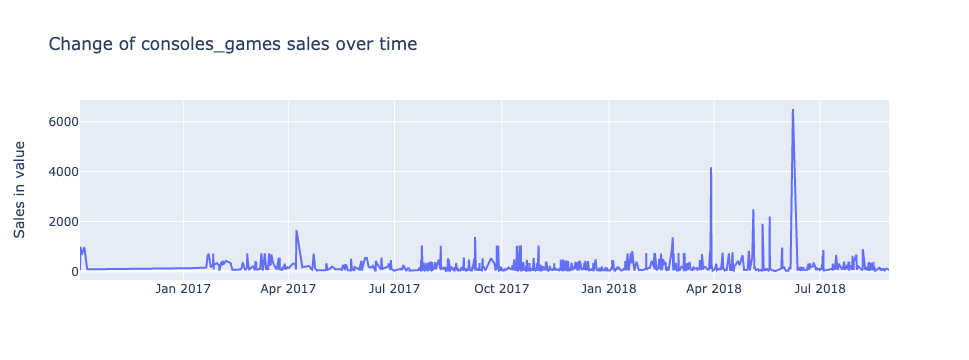

In [125]:
df_cat = select_category_df(df_intermediate, selected_category, 'order_purchase_timestamp')
fig = plot_sales_over_time(df_cat, selected_category, 'order_purchase_timestamp')

fig.show()

As we can see, between Oct 2016 and Jan 2017 there are a large gap between sales. We should drop the records before Jan 2017 to avoid adding noise to the dataset.

In [126]:
df_intermediate = df_intermediate[df_intermediate["order_purchase_timestamp"] >= '2017-01-01 00:00:00']
df_intermediate

,product_id,seller_id,price,freight_value,product_category_name,product_name_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_timestamp,estimated_delivery_time
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,58.0,4.0,1.0,credit_card,2.0,72.19,2017-09-13 08:59:02,15
1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,pet_shop,56.0,2.0,1.0,credit_card,3.0,259.83,2017-04-26 10:53:06,18
2,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,moveis_decoracao,59.0,2.0,1.0,credit_card,5.0,216.87,2018-01-14 14:33:31,21
3,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,perfumaria,42.0,1.0,1.0,credit_card,2.0,25.78,2018-08-08 10:00:35,11
4,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,ferramentas_jardim,59.0,1.0,1.0,credit_card,3.0,218.04,2017-02-04 13:57:51,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113378,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,utilidades_domesticas,43.0,3.0,1.0,boleto,1.0,343.40,2018-04-23 13:57:06,24
113379,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,informatica_acessorios,31.0,1.0,1.0,boleto,1.0,386.53,2018-07-14 10:26:46,17
113380,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,esporte_lazer,43.0,1.0,1.0,credit_card,3.0,116.85,2017-10-23 17:07:56,17
113381,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,informatica_acessorios,56.0,1.0,1.0,credit_card,3.0,64.71,2017-08-14 23:02:59,10


Here is how the graph would look like after removing those records:

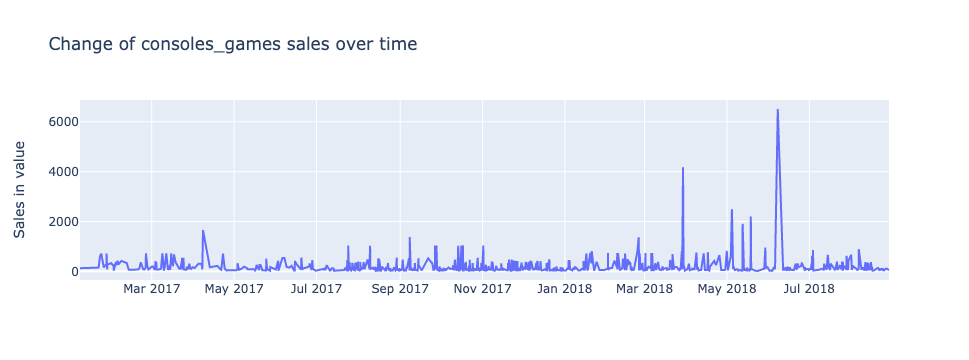

In [127]:
df_cat = select_category_df(df_intermediate, selected_category, 'order_purchase_timestamp')
fig = plot_sales_over_time(df_cat, selected_category, 'order_purchase_timestamp')

fig.show()

### Assigning each order with Week & Month numbers

In [128]:
oldest = min(df_intermediate.order_purchase_timestamp)
df_train = df_intermediate.copy()
df_train['month'] = list(map(lambda x: int(((x - oldest) // 30).days), df_train.order_purchase_timestamp))
df_train['week'] = list(map(lambda x: int(((x - oldest) // 7).days), df_train.order_purchase_timestamp))

df_train = df_train.drop('order_purchase_timestamp', axis=1)
df_train

,product_id,seller_id,price,freight_value,product_category_name,product_name_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,estimated_delivery_time,month,week
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,58.0,4.0,1.0,credit_card,2.0,72.19,15,8,35
1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,pet_shop,56.0,2.0,1.0,credit_card,3.0,259.83,18,3,15
2,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,moveis_decoracao,59.0,2.0,1.0,credit_card,5.0,216.87,21,12,53
3,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,perfumaria,42.0,1.0,1.0,credit_card,2.0,25.78,11,19,82
4,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,ferramentas_jardim,59.0,1.0,1.0,credit_card,3.0,218.04,40,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113378,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,utilidades_domesticas,43.0,3.0,1.0,boleto,1.0,343.40,24,15,67
113379,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,informatica_acessorios,31.0,1.0,1.0,boleto,1.0,386.53,17,18,79
113380,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,esporte_lazer,43.0,1.0,1.0,credit_card,3.0,116.85,17,9,41
113381,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,informatica_acessorios,56.0,1.0,1.0,credit_card,3.0,64.71,10,7,31


### Aggregating data into weekly/monthly sum

In [66]:
selected_metric = 'week'
dropped_metrics = 'month'

df_train = df_train.groupby([selected_metric, 'product_category_name'], as_index=False).sum()
df_train = df_train.drop(dropped_metrics, axis=1)

In [63]:
df_train

,week,price,freight_value,product_name_lenght,product_photos_qty,payment_sequential,payment_installments,payment_value,estimated_delivery_time
0,0,9682.69,1161.72,3904.0,169.0,83.0,170.0,9132.21,2733
1,1,18227.82,3068.55,8862.0,411.0,232.0,478.0,24598.72,7057
2,2,35841.35,5474.61,15119.0,774.0,325.0,944.0,56399.41,12294
3,3,63382.38,8424.91,22445.0,965.0,546.0,1449.0,95628.18,18771
4,4,70951.75,11949.39,27274.0,1383.0,627.0,1638.0,91965.57,19094
...,...,...,...,...,...,...,...,...,...
81,81,240829.58,43084.48,94513.0,4272.0,2038.0,5203.0,344827.86,31762
82,82,315523.77,56478.07,128609.0,6001.0,2696.0,7310.0,473208.48,38402
83,83,253730.30,44670.53,100705.0,4603.0,2147.0,6129.0,347287.19,32718
84,84,201049.35,34670.53,87218.0,3946.0,1849.0,5041.0,261472.17,27902


In [134]:
yhat = model_fit.predict(len(series), len(series), typ='levels')
print(yhat)

[1374.41807883]


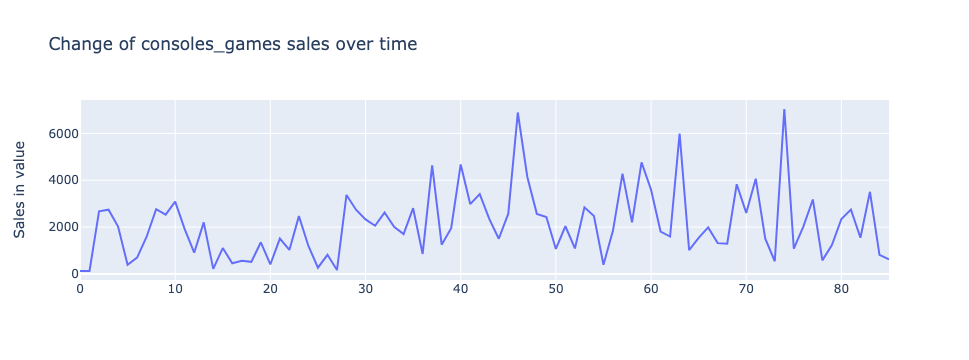

In [129]:
df_cat = select_category_df(df_train, selected_category, 'week')
fig = plot_sales_over_time(df_cat, selected_category, 'week')

fig.show()

# **Building the model**

## Spling data in test and train
- 80% train
- 20% test

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[[freq, 'price', 'freight_value', 'product_name_lenght', 'product_photos_qty', 'estimated_delivery_time']],
    df_train['payment_value'],
     test_size=0.2,
#     random_state=42,
    shuffle=False)

X, y = df_train[freq], df_train.payment_value

## Fiting Decision Tree Regressor for 2 and 5 max depth

In [131]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

## Ploting the results

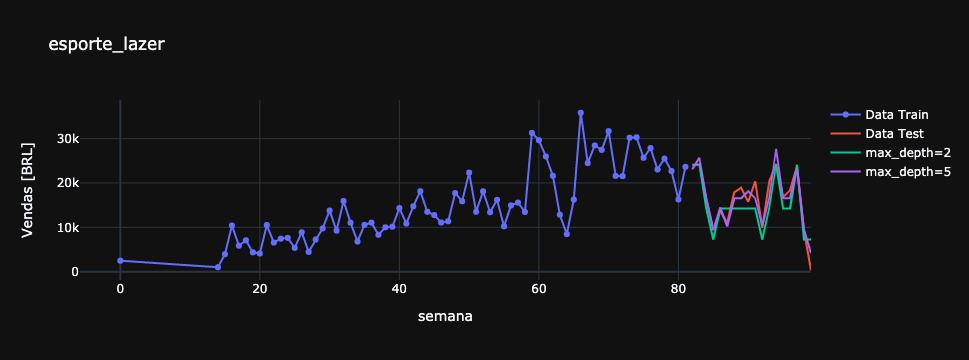

In [72]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name='Data Train',
    x = X_train[freq], 
    y = y_train,
    mode='markers+lines'
    ))

fig.add_trace(go.Scatter(
    name='Data Test',
    x = X_test[freq], 
    y = y_test,
    mode='lines'
    ))

fig.add_trace(go.Scatter(
    name="max_depth=2",
    x = X_test[freq],
    y = y_1,
    mode='lines'
    ))

fig.add_trace(go.Scatter(
    name="max_depth=5",
    x = X_test[freq],
    y = y_2,
    mode='lines'
    ))

fig.update_layout(
    title= filter,
    template='plotly_dark',
    xaxis_title=freq,
    yaxis_title='Vendas [BRL]')

fig.show()

In [5]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


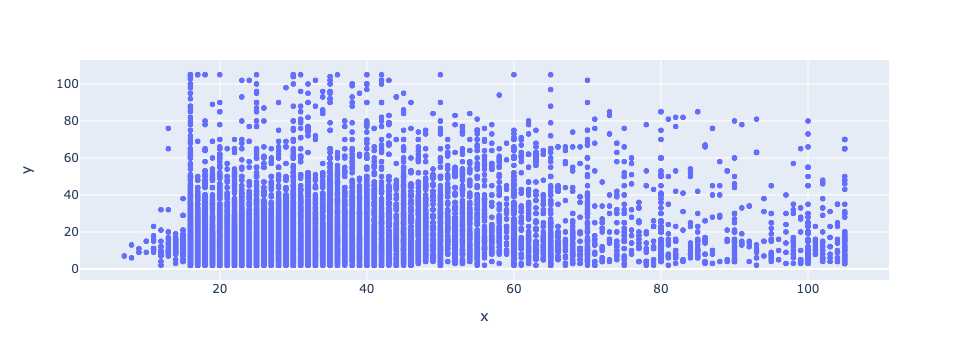

In [133]:
fig = px.scatter(x=df_products['product_length_cm'], y=df_products['product_height_cm'])
fig.show()

## Taking a close look at the predictions

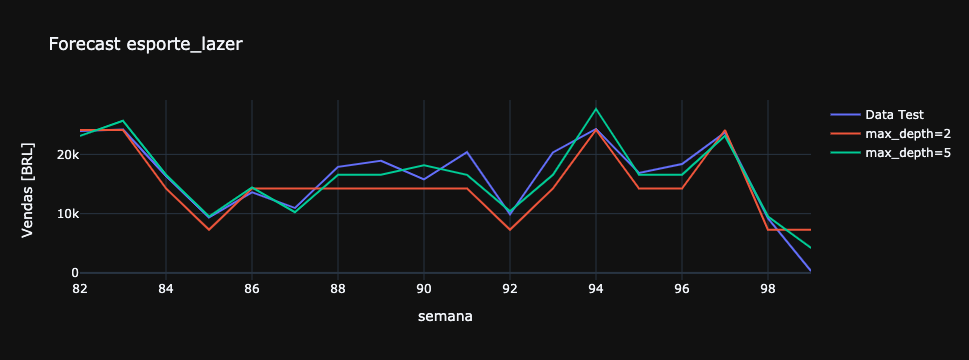

In [73]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name='Data Test',
    x = X_test[freq], 
    y = y_test,
    mode='lines'
    ))

fig.add_trace(go.Scatter(
    name="max_depth=2",
    x = X_test[freq],
    y = y_1,
    mode='lines'
    ))

fig.add_trace(go.Scatter(
    name="max_depth=5",
    x = X_test[freq],
    y = y_2,
    mode='lines'
    ))

fig.update_layout(
    title= (f'Forecast {filter}'),
    template='plotly_dark',
    xaxis_title= freq,
    yaxis_title='Vendas [BRL]')

fig.show()

## Ploting Error for each prediction

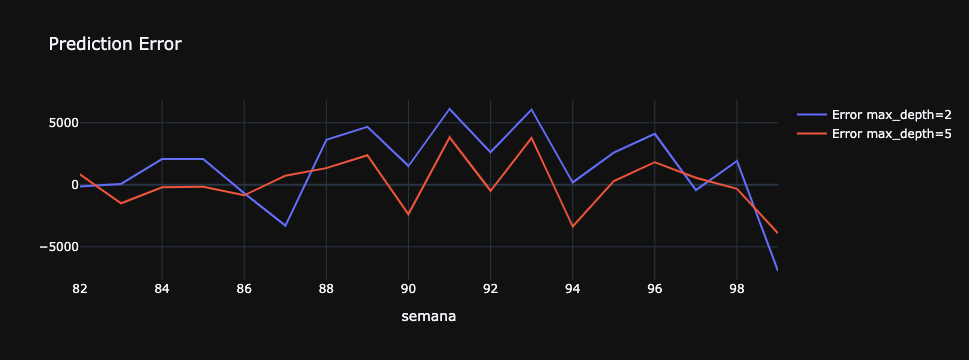

In [74]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Error max_depth=2",
    x = X_test[freq],
    y = y_test - y_1,
    mode='lines'
    ))

fig.add_trace(go.Scatter(
    name="Error max_depth=5",
    x = X_test[freq],
    y = y_test - y_2,
    mode='lines'
    ))

fig.update_layout(
    title= (f'Prediction Error'),
    template='plotly_dark',
    xaxis_title= freq)

fig.show()

## R2

R2 for max_depth=2

In [75]:
r2_score(y_test, y_1, sample_weight=None)

0.7017552082659942

R2 for max_depth=5

In [76]:
r2_score(y_test, y_2, sample_weight=None)

0.892884478527442